<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 31 January 2017</td>
<td style="text-align: right;"><a href="https://www.github.com/douglask3/fire_limitation">github.com/douglask3/fire_limitation</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying wood and moisture control on fire radiative power</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>2 </sup>Ioannis Bistinas, 
<sup>3 </sup>Rhys Whitley
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Vrije Universiteit Amsterdam, Faculty of Earth and Life Sciences, Amsterdam, Netherlands
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the parameters of a "liberative" fire radiative power model (defined below). This is a slightly different way of looking at control models then the limitation model describing burnt area in the same repo (see "master" branch). In this model, the availability of a control (i.e, tree cover) always allows maxmium of the modelled varaible, in this case FRP)
    
The model is driven by three covariate controls (X<sub>i=1, 2, ... M</sub>): available wood (using tree cover as a proxy), soil moisture and peat depth. The models target is observations of fire radiative power (Y).
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### 2.1 Model description
$FRP$ is the product of three controls: tree cover ($TC$), soil moisture ($W$) and peat depth ($P$). $FRP$ has a lower bound of $FRP_{min} > 0$, loosely defined as the minimum required power to allow fire to start and spread. i.e $FRP  \in  (FRP_{min}, \infty]$. To describe limitations on FRP, we first need to transform $FRP$ to be have a maximum possible extent of $[0, 1]$. We can do this using a simple exponential decay function:

\begin{eqnarray}
    D_{x} &=& 1 - \exp(-a \cdot x) \in [0,1]\\[1em]
\end{eqnarray}
Where $a > 0$

$D(FRP)$ is therefore what we are going to try describe. Our hypothosis is that FRP first burns it's way through wood (therefore controlled by tree cover), before peat (controlled by soil moisture then depth to water table). We are therefore going to use a ``liberative'' (see https://docs.google.com/document/d/1XR06JoaxZnseouB25nbUTvMLh4nWxHxULX8QcPvwc0A/edit?usp=sharing for full argument as to why), which means we will be optimiziing for $1-D(FRP)$. i.e:

\begin{eqnarray}
    (1 - D_{x}) &=& \exp(-a \cdot x) \in [0,1]\\[1em]
\end{eqnarray}

This will actually make the final model look a bit prettier.

Each control is represented by a simple logistic curve, and our transformed $FRP$ ($1 - D(FRP)$) is represented as the product of these controls:
\begin{eqnarray}
    f(x) = \frac{1}{1 + e^{-k\cdot(x-x_0)}}
\end{eqnarray}

\begin{eqnarray}
    D^{*}(FRP) = 1 - D(FRP) \approx D_{max} \cdot \prod f(x) \\[1em]
\end{eqnarray}

Where $f(x)$ is the limitation imposed by control $x = TC, W, P$ and $D_{max}$ is to aid our model optimization. $x_0$ is the value of control $x$ when it imposes a limitation of 50\% on burnt area (i.e,$f(x) = 0.5$), and $k$ is the steepness of the logistic curve, equal to ¼ of the gradient at $x = x_0$. $k > 0$ for $TC$ and $P$, where $FRP$ increases with the control, whereas $k < 0$ for $W$  for which $FRP$ decreases. Combining these last three equations gives us our FRP model:

\begin{eqnarray}
    FRP = -\frac{1}{a} \cdot \log(D_{max} \cdot \prod f(x)) \\[1em]
\end{eqnarray}


This leaves 8 free parameters that need to be optimised against observations of FRP.  

Let's get that coded up

### Configure

First off, we need some libraries

In [30]:
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import pymc3  as pm3 
from   pymc3.backends import SQLite
from   scipy  import optimize
from   theano import tensor as tt

import matplotlib.pyplot as plt

Now define some paramters for later use. 

In [31]:
# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

# paths and parameters
sample_pc     = 10  ## This will be the percentage of data sampled. 
nIterations   = 10000 ## Amount of inference iteragtions
outPath       = "../data/frpVars.csv" ## Where our input data comes from
param_outpath = '../outputs/params.csv' ## Where we'll output our parameter values describing our parameter distributions
trace_db      = '../data/firemodel_trace10.db' ## A trace file will save our inference info

## 2.1 Fire liberation model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [32]:
def wood(tree_cover):
    """
    Definition to describe available wood from tree cover: while return the input; capability to be modified later.
    """

    return tree_cover

def moisture(soil_moisture):
    """
    Definition to describe moisture
    """
    return soil_moisture


def peat(soil_depth):
    """
    Definition for the measure of ignition
    """
    return soil_depth


from pdb import set_trace as browser
def sigmoid(x, x0, k, FUN = tt.exp):
    """
    Sigmoid function to describe limitation using tensor if possible
    """
    try:
        x = -k * (x - x0)
    except:
        browser()
    try:
        x = FUN(x)
    except:
        x = np.exp(x)
    
    return 1.0/(1.0 + x)


def LibFRP(f_wood, wood_0, wood_k,
           f_moisture, moisture_0, moisture_k,
           peat, peat0, peatk,
           D_max, a):

    D = D_max * np.product([sigmoid(f_wood, wood_0, wood_k),
                            sigmoid(f_moisture, moisture_0, -moisture_k),
                            sigmoid(f_peat, peat_k, peat_0)])
    
    FRP = (-1/a) * tt.log(D)
    return FRP
    

## 2.2 Import data

Load data and do any necessary transformation needed for the Bayesian modelling framework. Rows are defined as a fraction of total data points (above). For full optimiatizaion, we set at 10% (sample_pc in config section), but for testing purposes, we cam limit the number of rows imported to 2%.

In [33]:
def load_with_buffer(filename, line_select, **kwargs):
    s_buf = StringIO()
    line_select = np.sort(line_select)
    with open(filename) as file:
        count = -1
        lineN = -1
        for line in file:
            lineN += 1
            if lineN == 0 or lineN == line_select[count]:
                s_buf.write(line)
                count += 1
                if count == len(line_select): break
            
    s_buf.seek(0)
    df = pd.read_csv(s_buf,**kwargs)
    return df

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f): pass
    return i + 1

DATAPATH = os.path.expanduser(outPath)

nlines      = file_len(DATAPATH)
npoints     = round(sample_pc * nlines / 100)
line_select = np.random.choice(range(0, nlines), npoints, False)
fd          = load_with_buffer(DATAPATH, line_select)

   ba_km2   enso        frp  fuel_consumption        sm  tree_fraction  \
0     0.0  1.156   5.900000         27.485817  0.207204             61   
1     0.0  1.156  20.200001         94.103989  0.341334             13   
2     0.0  1.156  10.100000         47.051994  0.343930              6   
3     0.0  1.156  28.600000        133.236343  0.343930              9   
4     0.0  1.156  10.500000         48.915440  0.343930             10   

   kalimantan_peat  
0               15  
1               15  
2               15  
3               15  
4               15  


(0.0, 1000)

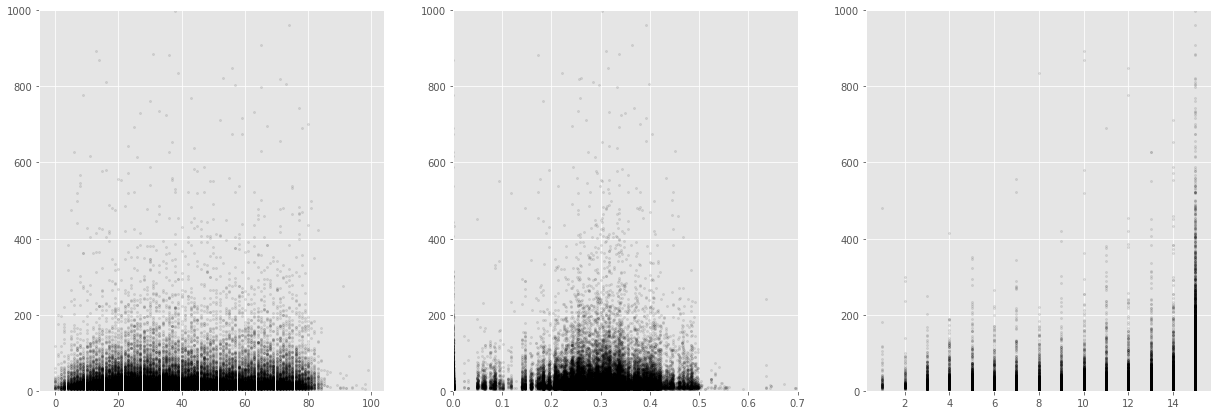

In [34]:
print(fd.head())

plt.figure(figsize=(21,7))
plt.subplot(131)
plt.scatter(fd['tree_fraction'], fd['frp'], c = 'k', alpha = 0.1, s = 5)
#plt.gca().set_yscale('log')
plt.ylim(0.0, 1000)

plt.subplot(132)
plt.scatter(fd['sm'], fd['frp'], c = 'k', alpha = 0.1, s = 5)
#plt.gca().set_yscale('log')
plt.xlim(0.0, 0.7)
plt.ylim(0.0, 1000)

plt.subplot(133)
plt.scatter(fd['kalimantan_peat'], fd['frp'], c = 'k', alpha = 0.1, s = 5)
#plt.gca().set_yscale('log')
plt.ylim(0.0, 1000)

Do a sanity check to make sure our data has imported correctly.

In [35]:
print(fd.info())
print(fd.head())
print(fd.max())
print(fd.min())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38207 entries, 0 to 38206
Data columns (total 7 columns):
ba_km2              38207 non-null float64
enso                38207 non-null float64
frp                 38207 non-null float64
fuel_consumption    38207 non-null float64
sm                  38207 non-null float64
tree_fraction       38207 non-null int64
kalimantan_peat     38207 non-null int64
dtypes: float64(5), int64(2)
memory usage: 2.0 MB
None
   ba_km2   enso        frp  fuel_consumption        sm  tree_fraction  \
0     0.0  1.156   5.900000         27.485817  0.207204             61   
1     0.0  1.156  20.200001         94.103989  0.341334             13   
2     0.0  1.156  10.100000         47.051994  0.343930              6   
3     0.0  1.156  28.600000        133.236343  0.343930              9   
4     0.0  1.156  10.500000         48.915440  0.343930             10   

   kalimantan_peat  
0               15  
1               15  
2               15  
3          

## 2.3 Baysian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the reponse of our _proposed understanding_ of this system as it varies with $X$.

### 2.3.1 Prior definitions
Because I have no idea what the uncertainty on the hyper parameters should look like (beyond $\beta> 0$), I've set them all as wide, standard distrubtions, spread generously beyound what is realistic plausable. Our full prior looks like this:

\begin{eqnarray}
P(x_0) = P(\sigma) &=& \mathcal{N}(0.5, 0.5) \\
    P(k_x) &=& \mathcal{exp}(0.1) \\
    P(D_{max})  &=& \mathcal{exp}(1) \\
    P(\sigma) &=& \mathcal{N_{1/2}}(1) \\[1.5em]
    P(a) &=& \mathcal{exp}(1) \\
\end{eqnarray}

We're going to consider the set of piors for calculating $D^{*}$ to start with:
\begin{eqnarry}
    P(\beta) &=& \prod_{x=1}^{4}\mathcal{S}(P(x_0),P(k_x)) \cdot P(D_{max}) \cdot P(\sigma) \\[1.5em]  
\end{eqnarray}

This is because the above loosly describes a (albeit slightly skewed) Normal distribution, so we can approximate our error ($\sigma$) with a normal distibution. We could use an exponential distribution instead to describe our full model. However, in the implmentation below, this would mean log transforming $D^{*}$ as well. Modelling our error in $D^{*}$ basically means we can skip an extra calculation. Also, I'm more comfortable withhow to code up the implementtation this way.

Back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `fire_error` as that is what we are trying to Quantify.



In [36]:
with pm3.Model() as fire_error:
    
    D_max          = pm3.Exponential('D_max'         ,        1.0)
    
# first for the sigmoids  
    wood_0         = pm3.Normal     ('wood_0'        ,   50.0,  25.0)
    wood_k         = pm3.Exponential('wood_k'        ,      10.0)
    
    moisture_0     = pm3.Normal     ('moisture_0'    ,  0.5,  0.5)
    moisture_k     = pm3.Exponential('moisture_k'    ,        0.1)
    
    peat_0         = pm3.Normal     ('peat_0'        ,  7.5,  4)
    peat_k         = pm3.Exponential('peat_k'        ,        1.0)
    
    a              = pm3.Exponential('a'             ,        1.0)
    
# describe the standard deviation in the error term
    sigma = pm3.HalfNormal('sigma', sd=1.0)

### 2.3.2 Likelihood definition

As already described above, we define the model error as approximating a normally distributed (i.i.d.).. We're describing the error (transformed observations, $y$ minus model predictions $F$) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(F, \sigma) \\[1em]
    \mathcal{N}(F, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - F_{ i}}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $y_i$ is a set of transformed observations we're attempting to optimise on. We get $y$ from the observations as per $D^{*}$ equation:

\begin{eqnarray}
    y &=& \exp(-a \cdot FRP)
\end{eqnarray} 


Below is the code that describes the above:

In [37]:
with fire_error:    
    # transform hyper-covariates 
    f_wood        = fd["tree_fraction"].values   
    f_moisture    = fd["sm"].values  
    f_peat        = fd["kalimantan_peat"].values
    
    # FRP is assumed to be transformed product of the 4 sigmoids
    # Not quiet sure if I should put this in its own function. Maybe at some point, this should still work...
    
    prediction = LibFRP(f_wood, wood_0, wood_k,
           f_moisture, moisture_0, moisture_k,
           peat, peat_0, peat_k,
           D_max, a)
    # calculate the error between observed and predicted FRP
    error = pm3.Normal('error', mu = prediction, sd = sigma, observed = fd['frp'].values)

### 2.3.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out - but TBH it doesn't matter if we're getting a reasonable convergence.

In [38]:
with fire_error:
    
    # help the sampling out by quickly finding an optimal start position
    #start = pm3.find_MAP(model=fire_error.model, fmin=optimize.fmin_powell)
    
    # set the step-method (criteria algorithm for moving around information space)
    step = pm3.Metropolis()
    
    # save our sampling to disk so we can access it later
    #db_save = SQLite(trace_db)
    
    # do the sampling
    mcmc_traces = pm3.sample(nIterations, step=step, njobs= -1)#, trace=db_save)#, start=start

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [a_log__]
>Metropolis: [peat_k_log__]
>Metropolis: [peat_0]
>Metropolis: [moisture_k_log__]
>Metropolis: [moisture_0]
>Metropolis: [wood_k_log__]
>Metropolis: [wood_0]
>Metropolis: [D_max_log__]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [22:30<00:00,  7.77it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Reload

In [39]:
#with fire_error:
#    mcmc_traces = pm3.backends.sqlite.load(trace_db)

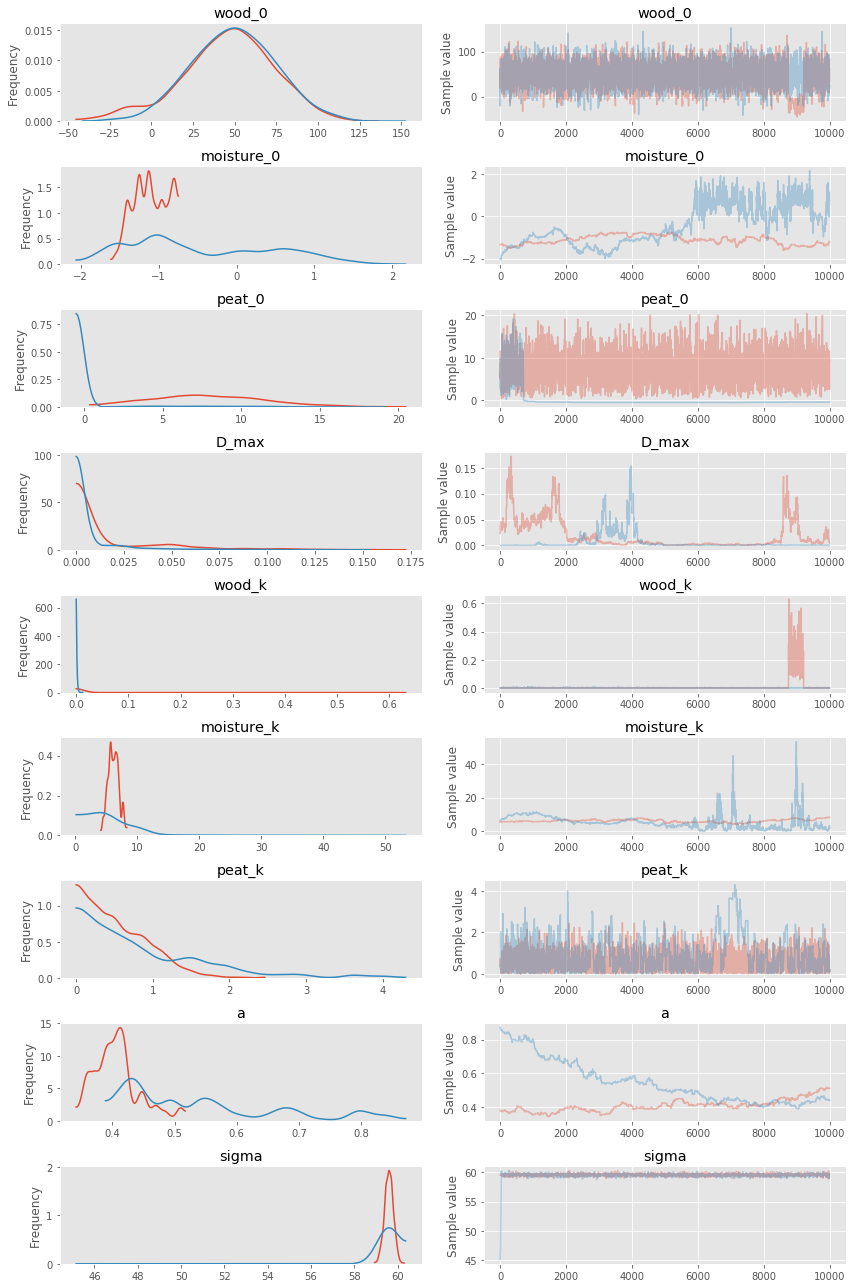

In [40]:
pm3.traceplot(mcmc_traces);

The iterations at the start are just letting the optimization settle. So we will only sample to last 20% of iterations for futher analysis. Here, exporting to netcdf for others to do their own analysis

In [41]:
varnames = mcmc_traces.varnames
print(varnames)

def cutFirstX(varname, ncut = 80):           
    vals = mcmc_traces.get_values(varname)
    ncut = round(len(vals) * ncut / 200)
    
    vals = np.reshape(vals, [2, 10000])[:,ncut:].flatten()
    return(vals)

#cutFirstX('wood_0')
vals = np.array([cutFirstX(i) for i in varnames])
vals = pd.DataFrame(np.array(vals).T, columns=varnames)
vals.to_csv(param_outpath, index=False)


['D_max_log__', 'wood_0', 'wood_k_log__', 'moisture_0', 'moisture_k_log__', 'peat_0', 'peat_k_log__', 'a_log__', 'sigma_log__', 'D_max', 'wood_k', 'moisture_k', 'peat_k', 'a', 'sigma']


## Plotting

Let look at the pdf of the last 20% of iterations for each parameter

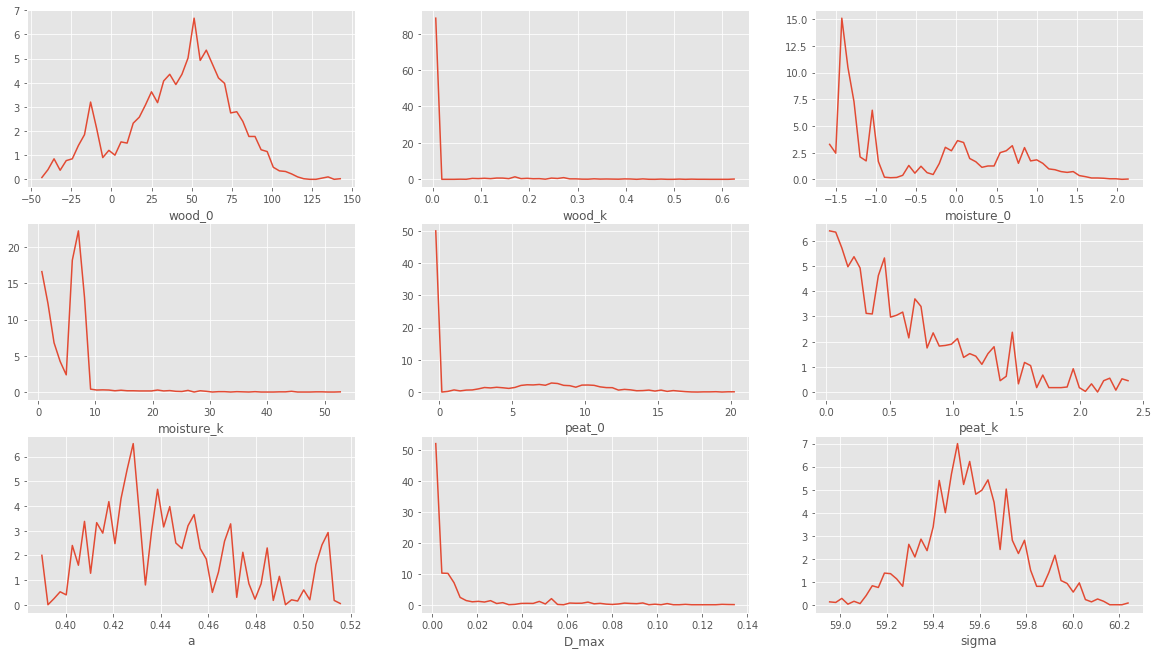

In [42]:
variables2Plot = ['wood_0'       , 'wood_k',
                  'moisture_0'   , 'moisture_k',
                  'peat_0'       , 'peat_k',
                  'a', 'D_max', 'sigma']

nvar = len(variables2Plot)
npcol = 4
nprow = np.ceil(nvar / npcol)

plt.figure(figsize=(20,5 * nprow))
def plotVar(var1, pn):
    plt.subplot(npcol, nprow, pn)
    param = vals[var1]
    
    hist, bins = np.histogram(param, bins=50)
    hist = 100.0 * hist / np.sum(hist)
    bins = bins[1:] - np.diff(bins)/2
    plt.plot(bins, hist)
    plt.xlabel(var1)
    
pn = 0
for i in variables2Plot:
    pn = pn + 1
    plotVar(i, pn)

### Some tests

In [43]:
fd.head()
#1.0 - np.exp(fd["frp"].values)
#vals.head()

,ba_km2,enso,frp,fuel_consumption,sm,tree_fraction,kalimantan_peat
0,0.0,1.156,5.900000,27.485817,0.207204,61,15
1,0.0,1.156,20.200001,94.103989,0.341334,13,15
2,0.0,1.156,10.100000,47.051994,0.343930,6,15
3,0.0,1.156,28.600000,133.236343,0.343930,9,15
4,0.0,1.156,10.500000,48.915440,0.343930,10,15


(0.5, 0.0, 0.0, 1.0)


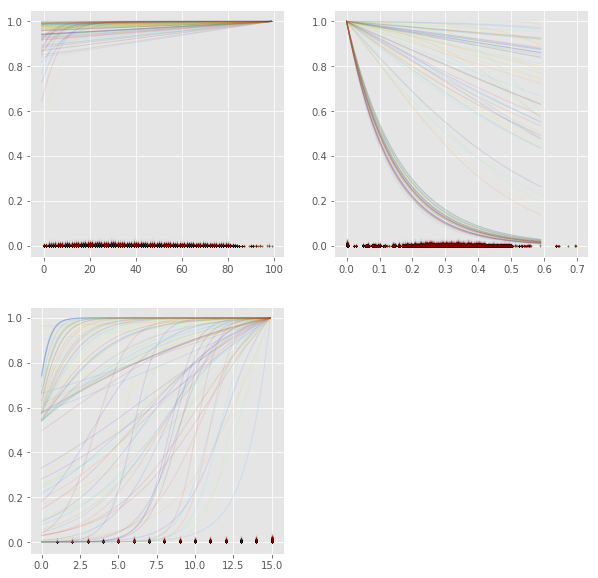

In [50]:
from pdb import set_trace as browser
import matplotlib.colors as colors
import matplotlib.cm as cmx

nsamples = 100

cNorm  = colors.Normalize(vmin=0, vmax=nsamples)
jet = cm = plt.get_cmap('jet') 

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.to_rgba(nsamples))

psamples = np.random.choice(range(len(vals)), nsamples, replace = False)
def plotControl(vname, x, x0, k, kscale = 1.0):

    for i, j in zip(psamples, range(nsamples)):
        plt.scatter(fd[vname].values, np.exp(-vals['a'][i] * fd["frp"].values) * vals["D_max"][i], c=scalarMap.to_rgba(j), s = 1, alpha = 0.01)

        frp_sim = sigmoid(x, vals[x0][i], vals[k][i] * kscale, np.exp)
        if kscale < 0.0: 
            frp_sim /= sigmoid(0.0, vals[x0][i], vals[k][i] * kscale, np.exp)
        else:
            frp_sim /= sigmoid(x.max(), vals[x0][i], vals[k][i] * kscale, np.exp)
        
        plt.plot(x, frp_sim, c = scalarMap.to_rgba(j), alpha = 0.1,linewidth=1)
        

plt.figure(figsize=(10, 10))
plt.subplot(221)
plotControl("tree_fraction",  np.arange(-1.0, 100.0), 'wood_0', 'wood_k')
plt.subplot(222)
plotControl("sm",  np.arange(0, 0.6, 0.01), 'moisture_0', 'moisture_k', -1.0)
plt.subplot(223)
plotControl("kalimantan_peat",  np.arange(0, 15, 0.1), 'peat_0', 'peat_k')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
#plt.xlim(0.1, 100)

In [ ]:
cfor i in range(20):
    frp_wood = np_sigmoid(fd["tree_fraction"].values, vals['wood_k'][i], vals['wood_x0'][i])
    plt.scatter(fd["tree_fraction"].values, frp_wood, c='r')

And what to the sigmoids look like?

In [ ]:
from pdb import set_trace as browser

def pltVsFire(x, xlab, pnt = 'o', *args, **kw):
    plt.plot(x, fd.fire, pnt, alpha = 0.03, *args, **kw)
    plt.xlabel(xlab)
    
def np_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + np.exp(-k*(x - x0)))

def returnSigmoid(x, k, x0):
    return np_sigmoid(x, k, x0)
    
def meanParam(x, x0, k, kmult = 1.0):
    x0 = np.mean(vals[x0])
    k  = np.mean(vals[k]) * kmult

    return returnSigmoid(x, k, x0)

def randomParam(x, x0, k, kmult = 1.0, size = 100):
    ps = np.random.choice(vals.shape[0], size = size, replace = False)
    return [returnSigmoid(x, vals[k][i] * kmult, vals[x0][i]) for i in ps]

In [ ]:
plt.figure(figsize=(10, 10))

####################
## Fuel           ##
####################
plt.subplot(2, 2, 1)
## scatter plot
fp = np.mean(vals['fuel_pw'])
fg = np.mean(vals['fuel_pg'])
cNPP = 1.0#np.mean(vals['cNPP'])

f_fuel = fuel_load(fd["vegCover"].values, fd["alphaMax"].values, fp, fg)
print(f_fuel.max())
pltVsFire(f_fuel, "NPP (g/m$^2$)", 'go')

## Line of best fit
#Fuel = np.arange(-6, fd.fuel.max(), 0.01)
Fuel = np.arange(0, f_fuel.max(), 0.01)
r_fuel = randomParam(Fuel, 'fuel_x0', 'fuel_k')
#NPP = np.exp(Fuel)
for r in r_fuel: plt.plot(Fuel, r, 'k', alpha=.01)

## cfg plot
#plt.xscale('log')
#plt.xlim([0.5, fd.NPP.max()])

####################
## Moisture       ##
####################
plt.subplot(2, 2, 2)
## scatter plot
Fmax = np.mean(vals['max_f'])
cM = np.mean(vals['cM'])
cMT = np.mean(vals['cMT'])
f_moisture = moisture(fd["alpha"].values, fd["emc"].values, fd["treecover"].values, cM, cMT)
pltVsFire(f_moisture , "Moisture = $\\alpha$ + M $\cdot$ EMC",'bo')

## Line of best fit
mst = np.arange(0.0, f_moisture.max(), 0.05)
r_moisture = randomParam(mst, 'moisture_x0', 'moisture_k', -1.0)
for r in r_moisture: plt.plot(mst, r, 'k', alpha=.01)

    
plt.ylim(0, 1)

####################
## Igntions       ##
####################
plt.subplot(2, 2, 3)
## scatter plot 
cP  = np.mean(vals['cP1'])
cC  = np.mean(vals['cC' ])
cD1 = np.mean(vals['cD1'])
igniteMax = 10

f_ignite = ignition(fd["lightning_ignitions"].values, \
                    fd["cropland"].values, \
                    fd["pasture"].values, \
                    fd["population_density"].values, \
                    cC, cP, cD1)
#f_ignite = np.exp(f_ignite)
pltVsFire(f_ignite, "Ignitions events = Lightn + P $\cdot$ Pop Dens + D1 $\cdot$ Pasture")

## Line of best fit
Ignite = np.arange(0.0, igniteMax, 0.1)
#Ignite = np.exp(Ignite)
#=Ignite = np.arange(0.0, 10000, 1)
r_Ignite = randomParam(Ignite, 'igntions_x0', 'igntions_k')
#yay = returnSigmoid(Ignite, 10, 1.0)
#Ignite = np.exp(Ignite)
for r in r_Ignite: plt.plot(Ignite, r, 'k', alpha=.01)

#plt.plot(Ignite, yay, 'red')

    
## cfg plot
#plt.xscale('log')
plt.xlim(0, igniteMax)

####################
## Suppression    ##
####################
plt.subplot(2, 2, 4)
#scatter plot
cP2 = np.mean(vals['cP2'])
cD2 = np.mean(vals['cD2'])
maxF = np.mean(vals['max_f'])
f_suppression = maxF * supression(fd["cropland"].values, \
                           fd["cropland"].values, \
                           fd["population_density"].values, \
                           cP2,
                           cD2)

pltVsFire(f_suppression, "Suppression = Cropland + D2 $\cdot$ Pop den")

# Line of best fit
Suppress = np.arange(0, 100, 0.01)
r_suppression = randomParam(Suppress, 'suppression_x0', 'suppression_k', -1.0)
for r in r_suppression: plt.plot(Suppress, r * Fmax, 'k', alpha=.01)

plt.xlim(0, 100)
plt.ylim(0, 1)